# Convert COMSOL data to PARC data

This notebook is used to convert COMSOL simulation data into tensors suitable for deep learning.
It aggregates the data from a parametric sweep into tensors of shape (N_timesteps, X, Y, N_features)

The input data is in the form of a csv file with the following columns:
x0 | y0 | t1 | t2 | t3 | ... | tN
x0 | y1 | t1 | t2 | t3 | ... | tN
x0 | y2 | t1 | t2 | t3 | ... | tN
...

where t1, t2, t3, ... are the time steps.

The output data is then stored as hdf5 files with the structure of the-well format.
In our case, theta and p_cap are parameters while the strucID is a starting condition,
i.e. the trajectory.

In [42]:
import re
from pathlib import Path
from typing import Dict, Tuple, Any

import pandas as pd
import numpy as np

def search_comsol_data(data_path: Path, params: list[str]) -> Dict[Tuple[int, int, float], Dict[str, Any]]:
    """
    Search through velocities, pressure, and phase_boundary folders to find and group
    files with matching parameter combinations.

    Args:
        data_path (Path): Base path containing the subdirectories

        params (list[str]): List of parameters to extract from the filenames

    Returns:
        Dict: Dictionary with parameter combinations as keys and file information as values
    """
    # Define the subdirectories to search
    subdirs = ["velocities", "pressure", "phase_boundary"]
    data = {}

    # Function to extract parameters from filename
    def extract_params(filename: str, params: list[str]) -> tuple:
        param1 = re.search(rf"{params[0]}_(\d+)", filename).group(1)
        param2 = re.search(rf"{params[1]}_(\d+)", filename).group(1)
        param3 = re.search(rf"{params[2]}_(\d+\.?\d*)", filename).group(1)

        # Transform theta from radians to degrees
        param3 = float(param3)
        param3 = np.rad2deg(param3)
        # round theta to integer
        param3 = int(np.round(param3))

        return (int(param1), int(param2), param3)

    # Search through each subdirectory
    for subdir in subdirs:
        subdir_path = data_path / subdir
        if not subdir_path.exists():
            print(f"Warning: Directory {subdir} not found")
            continue

        files = subdir_path.glob("*.csv")
        for file in files:
            # Extract parameters
            param1, param2, param3 = extract_params(file.stem, params)

            # Create parameter combination key, only include p_cap and theta
            # strucID is not included since we want to aggregate over all strucIDs
            param_key = (param2, param3)

            # Initialize nested dictionaries if they don't exist
            if param_key not in data:
                data[param_key] = {}
            if param1 not in data[param_key]:
                data[param_key][param1] = {}

            # Add file path under appropriate category
            if "vel_u" in str(file):
                data[param_key][param1]["vel_u"] = file
            elif "vel_v" in str(file):
                data[param_key][param1]["vel_v"] = file
            elif "pressure" in str(file):
                data[param_key][param1]["pressure"] = file
            elif "phase_boundary" in str(file):
                data[param_key][param1]["phase_boundary"] = file

    return data


def load_comsol_csv(file_path: Path) -> np.ndarray:
    """
    Load COMSOL CSV data and reshape it into (time, x, y) format.
    """
    # Read CSV and sort by x then y coordinates
    df = pd.read_csv(file_path, sep=";", dtype=np.float32, header=None)
    df = df.sort_values(by=[df.columns[0], df.columns[1]]).reset_index(drop=True)

    # Get coordinate information
    x_coords = df[0].unique()
    y_coords = df[1].unique()

    # Calculate expected grid size and validate
    grid_size = len(x_coords) * len(y_coords)
    if len(df) != grid_size:
        raise ValueError(
            f"Data grid mismatch: {len(df)} points vs expected {grid_size} ({len(x_coords)}x{len(y_coords)})"
        )

    # Reshape directly to (x, y, time) then transpose to (time, y, x)
    time_steps = df.columns[2:]
    time_data = df[time_steps].values
    data = time_data.reshape(len(x_coords), len(y_coords), len(time_steps))

    return data.transpose(2, 0, 1)

In [44]:
# Load the data
raw_data_path = Path("/home/flwi01/Coding/MetaPARC/data/raw_comsol")
data_path = Path("/home/flwi01/Coding/MetaPARC/data/tasks/porous_twophase_flow")
data_path.mkdir(parents=True, exist_ok=True)
param_names = ["strucID", "p_cap", "theta"]

data = search_comsol_data(raw_data_path, param_names)

for data_key, data_value in data.items():
    trajectories = []
    for strucID, file_path in data_value.items():
        data_arrays = []
        for file_key, file_path in data_value[strucID].items():
            data_array = load_comsol_csv(file_path)
            data_arrays.append(data_array)

        data_arrays = np.array(data_arrays)  # (N_features, N_timesteps, X, Y)
        # Transpose to (N_timesteps, X, Y, N_features)
        data_arrays = data_arrays.transpose(1, 2, 3, 0)

        trajectories.append(data_arrays)

    trajectories = np.array(trajectories)  # (N_trajectories, N_timesteps, X, Y, N_features)


    name = f"p_cap_{data_key[0]}_theta_{data_key[1]}.npy"
    np.save(data_path / name, trajectories)


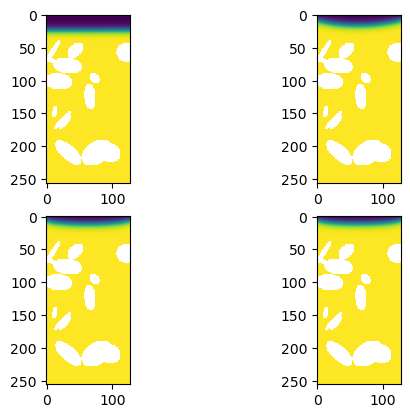

In [ ]:
import matplotlib.pyplot as plt

# Plot 4 data timesteps to check if correct

data = np.load(
    data_path
    / "strucID_0_p_cap_0_theta_110.npy"
)
feature = 3

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(data[0, :, :, feature])
axs[0, 1].imshow(data[100, :, :, feature])
axs[1, 0].imshow(data[200, :, :, feature])
axs[1, 1].imshow(data[300, :, :, feature])

plt.show()
